In [2]:
%cd '../HOTS'
from Tools import netparam, knn, JensenShannon, BattachaNorm, fit_jitter
import numpy as np
import matplotlib.pyplot as plt
import pickle
from os.path import isfile

/home/antoine/homhots/HOTS/HOTS


# Testing on the full dataset

In [12]:
sigma = None
pooling = False
homeinv = False
jitonic = [None,None] #[temporal, spatial]
jitter = False
R = 2
tau = 5
nbclust = [4,8,16]
filt = 2

timestr = '2021-03-29'
record_path = '../Records/EXP_03_NMNIST/'
dataset = 'nmnist'
nb_train = 60000
nb_test = 10000
ds = 1

nb_test = nb_test//ds
nb_train = nb_train//ds
print(f'training set size: {nb_train} - testing set: {nb_test}')

kNN = 12
verbose=False

training set size: 60000 - testing set: 10000


  0%|          | 5/1000 [22:21<74:10:35, 268.38s/it]


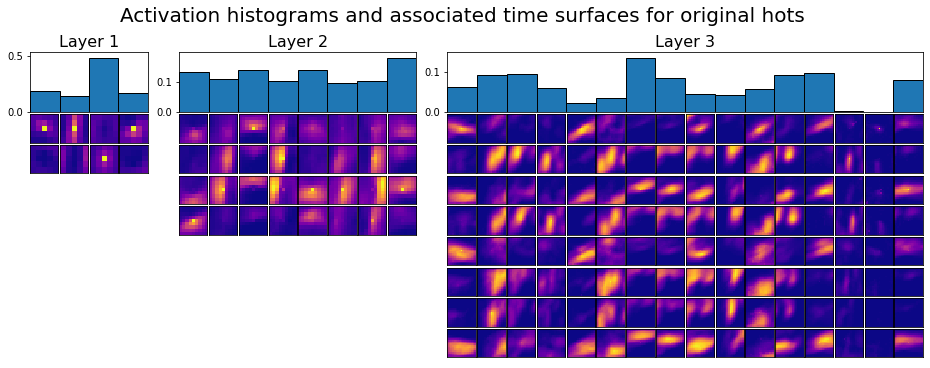

In [ ]:
for name in ['hots', 'homhots']:
    f_name = f'{record_path}{timestr}_results_fullset_histo_{name}.pkl'
    hotshom, homeotest = netparam(name, filt, tau, nbclust, sigma, homeinv, jitter, timestr, dataset, R)#, nb_learn=50)
    hotshom.plotlayer()
    if isfile(f_name):
        with open(f_name, 'rb') as file:
            scores = pickle.load(file)
    else:
        trainhistomap = hotshom.running(homeotest=homeotest, nb_digit = nb_train, outstyle='histo', dataset=dataset, verbose=verbose)
        testhistomap = hotshom.running(homeotest = homeotest, train=False, nb_digit=nb_test, jitonic=jitonic, dataset=dataset, verbose=verbose)
        JS_kNN_score = knn(trainhistomap,testhistomap, k = kNN, weights = 'distance', metric = JensenShannon)
        kNN_score = knn(trainhistomap,testhistomap, k = kNN, weights = 'distance')
        
        trainhistomapav = hotshom.running(homeotest=homeotest, nb_digit = nb_train, outstyle='histav', dataset=dataset, verbose=verbose)
        trainhistomapav2 = []
        for i in range(trainhistomapav.shape[0]):
            trainhistomapav2.append([i,trainhistomapav[i,:]])
        JS_score = knn(trainhistomapav2,testhistomap, k = 1, weights = 'uniform', metric = JensenShannon)
        BA_score = knn(trainhistomapav2,testhistomap, k = 1, weights = 'uniform', metric = BattachaNorm)
        EU_score = knn(trainhistomapav2,testhistomap, k = 1, weights = 'uniform')

        scores = [EU_score, BA_score, JS_score, kNN_score, JS_kNN_score]
        with open(f_name, 'wb') as file:
            pickle.dump(scores, file, pickle.HIGHEST_PROTOCOL)
        
    print('----------Averaged histograms----------')
    print(f'Performances for {name} with Euclidian distance: {np.round(scores[0],3)*100}%')
    print(f'Performances for {name} with Bhattacharyya distance: {np.round(scores[1],3)*100}%')
    print(f'Performances for {name} with Jensen-Shannon distance: {np.round(scores[2],3)*100}%')
    print('---------Per sample histograms---------')
    print(f'Performances for {name} with  k-NN (k={kmax}): {np.round(scores[3],3)*100}%')
    print(f'Performances for {name} with  k-NN using Jensen-Shannon as a metric (k={kmax}): {np.round(scores[4],3)*100}%')

# Testing on different folds

- trainset is composed of all avaible samples: 60 000 digits
- testset is divided into 10 folds of 1000 samples each

In [14]:
nb_test = 10000
ds = 10
nb_test = nb_test//ds
print(f'training set size: {nb_train} - testing set: {nb_test}')

training set size: 60000 - testing set: 1000


In [6]:
verbose = False
for name in ['hots','homhots']:
    f_name = f'{record_path}{timestr}_results_kfolds_{nb_test}_histo_{name}.pkl'
    hotshom, homeotest = netparam(name, filt, tau, nbclust, sigma, homeinv, jitter, timestr, dataset, R)#, nb_learn=50)
    trainhistomap = hotshom.running(homeotest=homeotest, nb_digit=nb_train, outstyle='histo', verbose = verbose)
    if isfile(f_name):
        with open(f_name, 'rb') as file:
            scores = pickle.load(file)
        print('results loaded')
    else:
        scores = []
        for i in range(ds):
            testhistomap = hotshom.running(homeotest=homeotest, train=False, nb_digit=nb_test, jitonic=jitonic, kfold = ds, kfold_ind=i, verbose=verbose)
            kNN_score = knn(trainhistomap,testhistomap, k = kNN, weights = 'distance')
            scores.append(kNN_score)
        with open(f_name, 'wb') as file:
            pickle.dump(scores, file, pickle.HIGHEST_PROTOCOL)
    print(f'Mean accuracy for {name} = {np.round(np.mean(scores),3)*100}% - std = {np.round(np.std(scores),3)*100}')

../Records/EXP_03_NMNIST/train/2021-03-29_lagorce_first_None_False_[0.25, 1]_[4, 8, 16]_[5.0, 50.0, 500.0]_[2, 4, 8]_True_60000_[None, None]_histo.pkl
Mean accuracy for hots = 87.0% - std = 1.0
../Records/EXP_03_NMNIST/train/2021-03-29_lagorce_rdn_None_True_[0.25, 1]_[4, 8, 16]_[5.0, 50.0, 500.0]_[2, 4, 8]_False_60000_[None, None]_histo.pkl
Mean accuracy for homhots = 87.9% - std = 1.4000000000000001


# Testing with different spatial and temporal jitter

- trainset is composed of all avaible samples: 60 000 digits
- testset is a subset composed of 1000 samples of the N-MNIST testset
- spatial and temporal jitter are applied separately to the testset

In [17]:
jit_s = np.arange(0,10,0.5)
jit_t = np.arange(0,300,10)
jit_s, jit_t = jit_s**2, jit_t**2

[    0   100   400   900  1600  2500  3600  4900  6400  8100 10000 12100
 14400 16900 19600 22500 25600 28900 32400 36100 40000 44100 48400 52900
 57600 62500 67600 72900 78400 84100]


In [16]:
for name in ['hots','homhots']:
    f_name = f'{record_path}{timestr}_results_jitter_{nb_test}_histo_{name}.pkl'
    if isfile(f_name):
        with open(f_name, 'rb') as file:
            score_t, jit_t, score_s, jit_s = pickle.load(file)
        print('results loaded')
    else:
        hotshom, homeotest = netparam(name, filt, tau, nbclust, sigma, homeinv, jitter, timestr, dataset, R)
        trainhistomap = hotshom.running(homeotest=homeotest, nb_digit=nb_train, outstyle='histo', verbose = verbose)
        score_s =[]
        score_t = []
        for i in jit_s:
            i = round(i,2)
            jitonic = [None,i]
            testhistomap = hotshom.running(homeotest = homeotest, train=False, nb_digit=nb_test, jitonic=jitonic, subset_size = nb_test, verbose = verbose)
            kNN_score = knn(trainhistomap,testhistomap, k = kNN, weights = 'distance')
            score_s.append(kNN_score)
        for j in jit_t:
            j = round(j,0)
            jitonic = [j,None]
            testhistomap = hotshom.running(homeotest = homeotest, train=False, nb_digit=nb_test, jitonic=jitonic, subset_size = nb_test, verbose = verbose)
            kNN_score = knn(trainhistomap,testhistomap, k = kNN, weights = 'distance')
            score_t.append(kNN_score)
        with open(f_name, 'wb') as file:
            pickle.dump([score_t, jit_t, score_s, jit_s], file, pickle.HIGHEST_PROTOCOL)

time jitter -> var = 22500



  1%|          | 8/1000 [00:04<11:02,  1.50it/s]

KeyboardInterrupt: 

In [ ]:
name = 'hots'
f_name = f'{record_path}{timestr}_results_jitter_{nb_test}_histo_{name}.pkl'

fig_s, ax_s = plt.subplots(1,1,figsize=(8,5))
fig_t, ax_t = plt.subplots(1,1,figsize=(8,5))

for name in ['hots', 'homhots']:
    f_name = f'{record_path}{timestr}_results_jitter_{nb_test}_histo_{name}.pkl'
    if isfile(f_name):
        print('results loaded')
        with open(f_name, 'rb') as file:
            score_t, jit_t, score_s, jit_s = pickle.load(file)
    else:
        verbose = False
        hotshom, homeotest = netparam(name, filt, tau, nbclust, sigma, homeinv, jitter, timestr, dataset, R)
        trainhistomap = hotshom.running(homeotest=homeotest, nb_digit=nb_train, outstyle='histo')
        score_s =[]
        score_t = []
        for i in jit_s:
            i = round(i,2)
            jitonic = [None,i]
            testhistomap = hotshom.running(homeotest = homeotest, train=False, nb_digit=nb_test, jitonic=jitonic, subset_size = nb_test, verbose = verbose)
            kNN = knn(trainhistomap,testhistomap, k = k, weights = 'distance')
            score_s.append(kNN)
        for j in jit_t:
            j = round(j,0)
            jitonic = [j,None]
            testhistomap = hotshom.running(homeotest = homeotest, train=False, nb_digit=nb_test, jitonic=jitonic, subset_size = nb_test, verbose = verbose)
            kNN = knn(trainhistomap,testhistomap, k = k, weights = 'distance')
            score_t.append(kNN)
        with open(f_name, 'wb') as file:
            pickle.dump([score_t, jit_t, score_s, jit_s], file, pickle.HIGHEST_PROTOCOL)

    param_t = [-2, 120, np.log(10*np.ones(1))]
    param_s = [0, 0, np.log(2*np.ones(1))]
    logistic_model_T, loss_T, fit_T = fit_jitter(param, jit_t, np.array(score_t), verbose=False)
    logistic_model_S, loss_S, fit_S = fit_jitter(param, jit_s, np.array(score_s), verbose=False)

    ax_s.plot(jit_s,score_s, label={name})
    ax_s.plot(jit_s, fit_S.detach().numpy(), alpha=0.2, lw=2)

    ax_t.plot(jit_t,score_t, label={name})
    ax_t.plot(jit_t, fit_T.detach().numpy(), alpha=0.2, lw=2)

    chance = np.ones([len(jit_s)])*0.1
    ax_s.plot(jit_s,chance, 'k--', label='chance level')
    ax_s.axis([0,max(jit_s),0,1])
    ax_s.set_xlabel('standard deviation of spatial jitter (in pixel)')
    ax_s.set_ylabel('accuracy')
    ax_s.set_title('Accuracy as a function of spatial jitter');
    ax_s.legend()

    chance = np.ones([len(jit_t)])*0.1
    ax_t.plot(jit_t,chance, 'k--', label='chance level')
    ax_t.axis([0,max(jit_t),0,1])
    ax_t.set_xlabel('standard deviation of temporal jitter (in $\mu s$)')
    ax_t.set_ylabel('accuracy')
    ax_t.set_title('Accuracy as a function of temporal jitter');
    ax_t.legend()
